In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegressiondf

#### Import raw data and background knowledge 

In [4]:
def isnull_df(df):
    print(df.isnull().sum())
def read_csv(file,delimiter=",", parse_dates=True):
    df = pd.read_csv(file, delimiter=",", parse_dates=True)
    return df

In [2]:
station_data = pd.read_csv("station_data.csv", delimiter=",", parse_dates=True)
trip_data = pd.read_csv("trip_data.csv", delimiter=",", parse_dates=True)
weather_data = pd.read_csv("weather_data.csv", delimiter=",", parse_dates=True)

In [3]:
moved_station_list = [23,85,25,86,49,87,69,88,72,89,90]
moved_station_pair = [[23,85],[25,86],[49,87],[69,88],[72,89],[89,90]]

#### Check invalid/NaN data and also the moved stations information  

In [ ]:
print(station_data.isnull().sum())
print(trip_data.isnull().sum())
print(weather_data.isnull().sum())

In [ ]:
trip_data.loc[trip_data['End Station'].isin(moved_station_list) 
              | trip_data['Start Station'].isin(moved_station_list)]

station_data.loc[station_data['Id'].isin(moved_station_list)]

# print()
# station_data['Name'].value_counts()
# station_data
# We could not use columns ['lat','Long] to identify the duplicated 
# replace them manually in the trip_data set


In [5]:
# replace the moved station with new IDs 
trip_data_ETL = trip_data
for before,after in moved_station_pair:
    trip_data_ETL['Start Station'] = trip_data_ETL['Start Station'].replace(before,after)
    trip_data_ETL['End Station'] = trip_data_ETL['End Station'].replace(before,after)

# convert the time into datetime type 
trip_data_ETL['Start Date'] = trip_data_ETL['Start Date'].apply(pd.to_datetime)
trip_data_ETL['End Date'] = trip_data_ETL['End Date'].apply(pd.to_datetime)

In [11]:
for before,after in moved_station_pair:
    station_data['Id'] = station_data['Id'].replace(before,after)

station_data_ETL = station_data.drop_duplicates(subset=['Id'], keep='last')

In [13]:
# trip_data_ETL.to_pickle('ETL.pkl')
# trip_data_ETL = pd.read_pickle('ETL.pkl')
# station_data_ETL.to_pickle('stationETL.pkl')

#### Identify the weather influence for renting the bike 
for example it is too windy that day
* return the bad weather \[date ,zip , weather condition which is not good for riding]

#### TODO concat those date and zip code for detecting the abnormal trip_data due to the weather 
 if the date match , the data could be outliers 

In [ ]:
# such as people do not prefer to use a bike when raining 
# weather_event=['Fog',Fog-Rain]
# print(weather_data[['Events']].describe())

print(weather_data['Events'].value_counts())
weather_event_list = (list(weather_data['Events'].value_counts().index))
print(weather_event_list)

# weather_data[weather_data['Events'].notnull().str.contains("Rain")]
weather_data[weather_data['Events'].notnull()][['Date','Zip','Events']]

# print(weather_data['Max Gust SpeedMPH'].isnull().sum())
weather_data[weather_data['Max Gust SpeedMPH'] > 0][['Date','Zip','Max Gust SpeedMPH']]

# Reference: Beaufort Wind Scale https://www.hwn.org/resources/bws.html
# Force 6 
# Strength: Strong Breeze 
# Speed: 25-31 mph, 40-50 kph 
# Observations: Large branches sway, flags beat and pop, larger waves with regular whitecaps

weather_data[weather_data['Max Wind SpeedMPH'] > 31][['Date','Zip','Max Wind SpeedMPH']]


#### Feature Engineering ON trip_data.csv ['Trip ID', 'Start Date', 'Start Station', 'End Date', 'End Station', 'Subscriber Type'] 

* 'Subscriber Type': "Subscriber" weight should be bigger than "Customer" as regularly user
* 'Trip ID' is reused for unknown pattern, for pair of "rent" | "return" 
    - eg. trip_data_ETL[trip_data_ETL['Trip ID']==913460]
    
* 'Start Date' and 'End Date' could saved into bins(interval as hour)

##### Connection among data set 
* Location relation : trip_data.%Station  <---- > station_data.City <---> weather_data.Zip
* Time seriel relation : trip_data.%Date <---> weather_data.Date

In [15]:
Ids = station_data_ETL['Id'].values
dockN = station_data_ETL['Dock Count'].values
station_dock = {}
for id , dock in zip(Ids,dockN):
    station_dock[id] = dock

### convert  raw data : records  -- > target data: matrix 
matrix [id,timestamp] = -1*records[start,timestamp] + 1* records[end,timestamp]

In [197]:
df_dict={}
for id in Ids:
#     trip_data_ETL
    minus = trip_data.loc[trip_data['Start Station'] == id]['Start Date']
    plus = trip_data.loc[trip_data['End Station'] == id]['End Date']
    df_i_minus = pd.DataFrame()
    df_i_minus['Time'] = minus.values
    df_i_minus['value']= [-1]*minus.shape[0]

    df_i_plus = pd.DataFrame()
    df_i_plus['Time'] = plus.values
    df_i_plus['value']= [1]*plus.shape[0]

    df_i = pd.concat([df_i_minus, df_i_plus])
    df_i = df_i.set_index('Time')
    df_i = df_i.sort_index()
    df = df_i.groupby(pd.TimeGrouper(freq='H')).sum().fillna(0)
    
    dock_left = [station_dock[id]]
    dock_leftX = [station_dock[id]]

    for index,value in list(enumerate(df['value'].values, start=0)):
        dock_left.append(dock_left[index]+value)
    df['stock'] = dock_left[1:]
    df_dict[id]=df
   

In [202]:
import pickle
with open('df_dict.pkl', 'wb') as handle:
    pickle.dump(df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


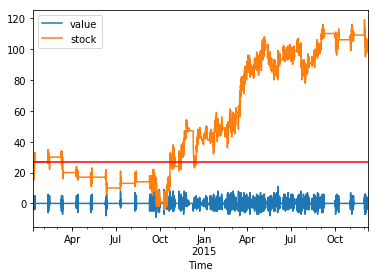

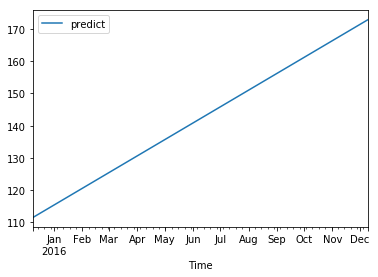

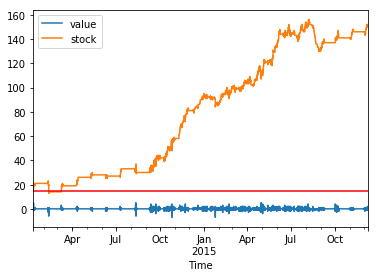

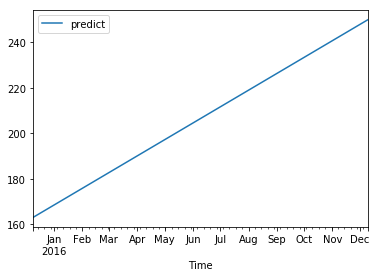

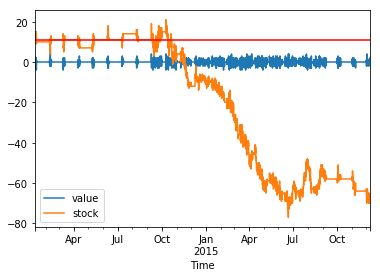

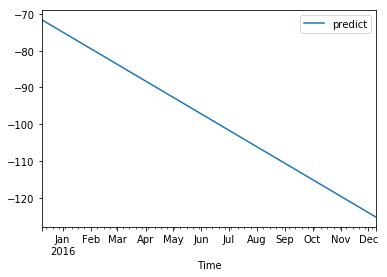

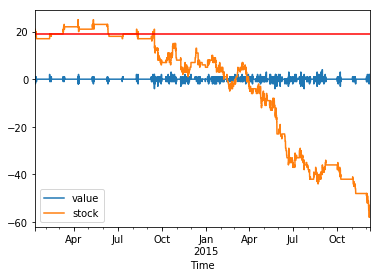

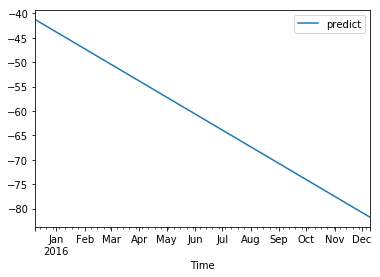

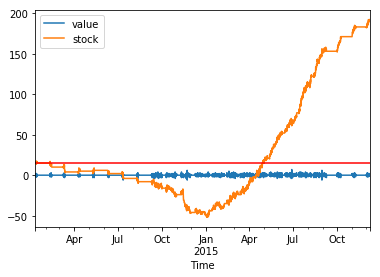

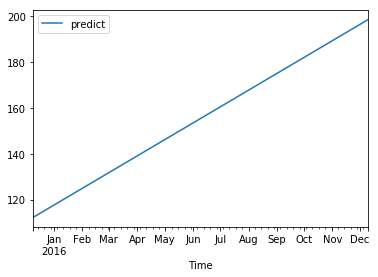

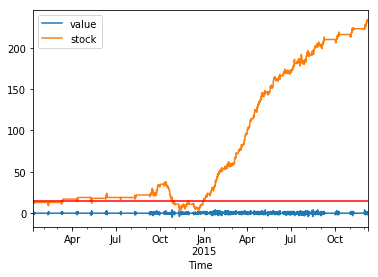

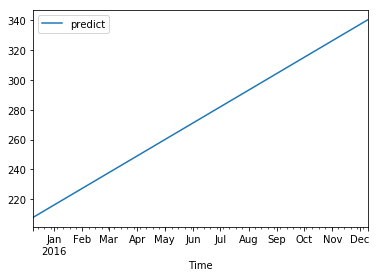

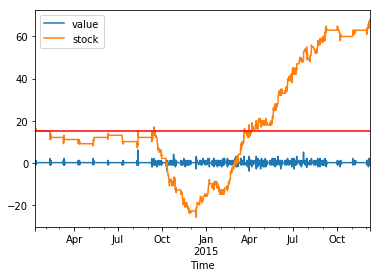

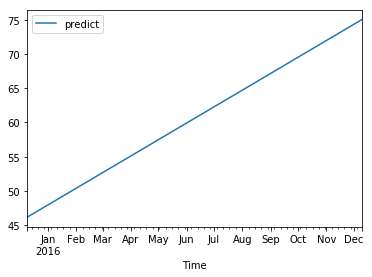

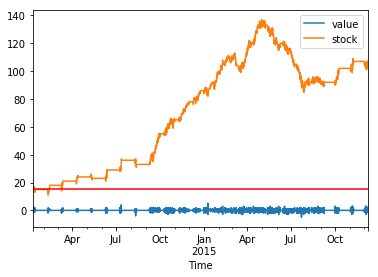

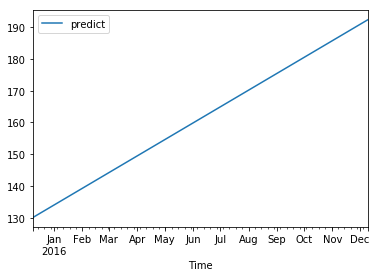

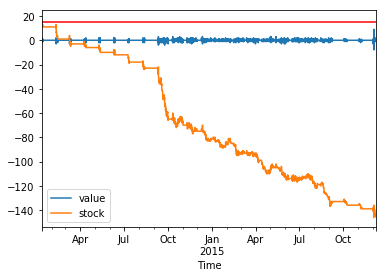

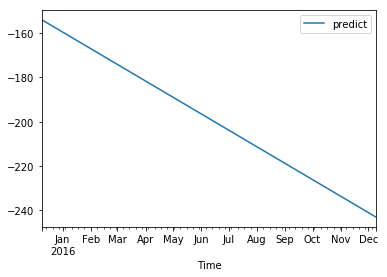

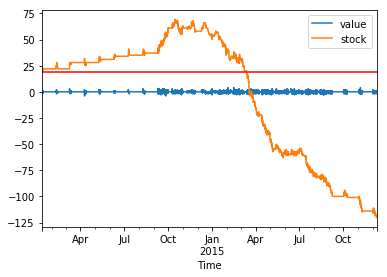

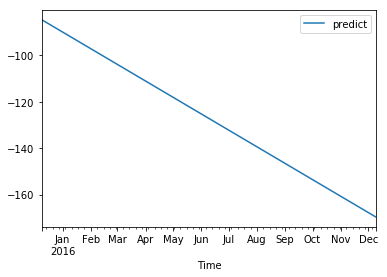

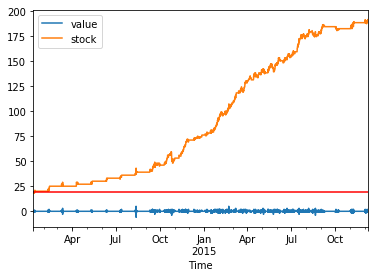

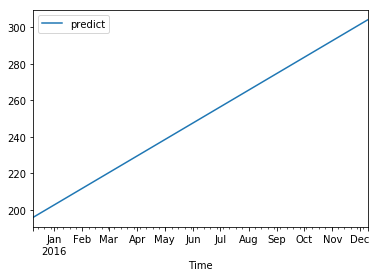

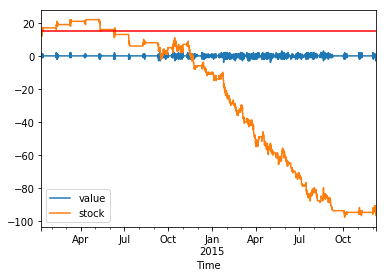

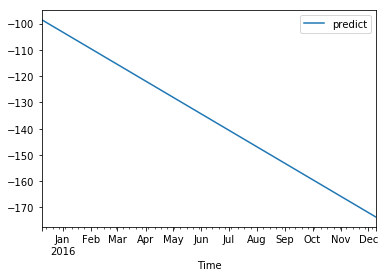

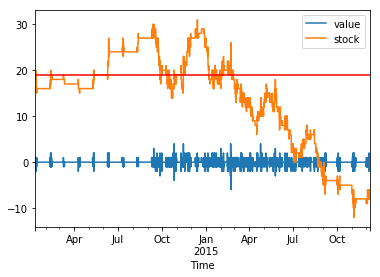

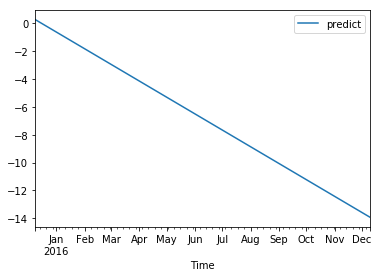

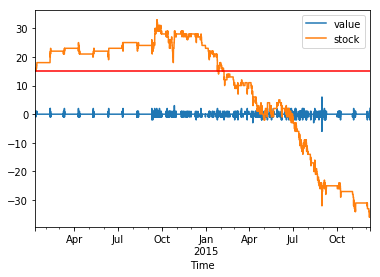

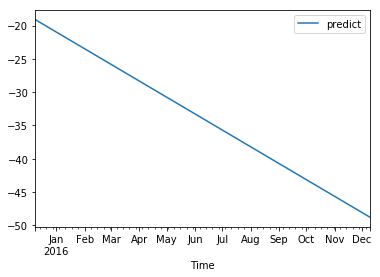

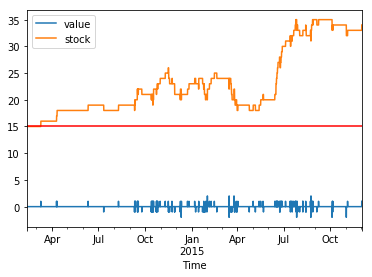

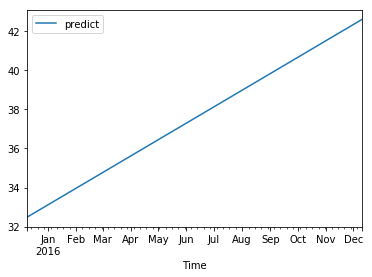

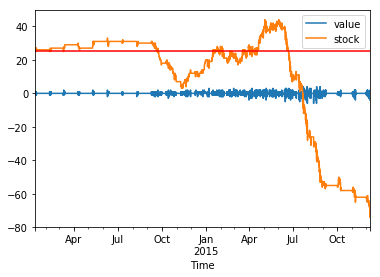

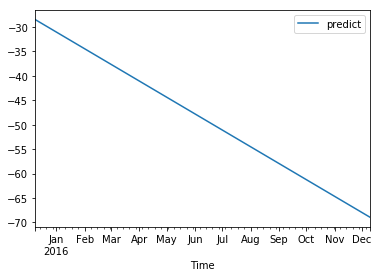

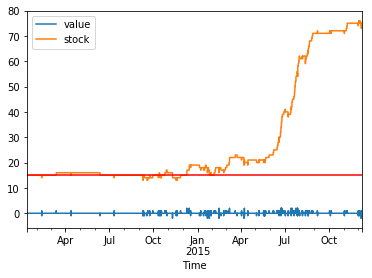

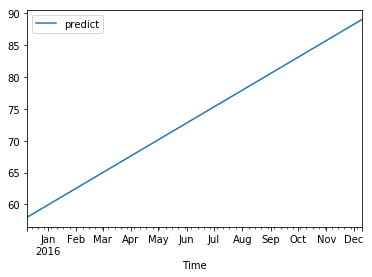

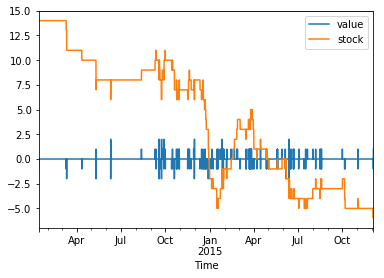

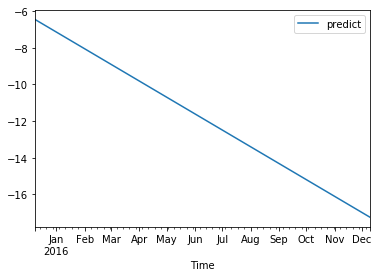

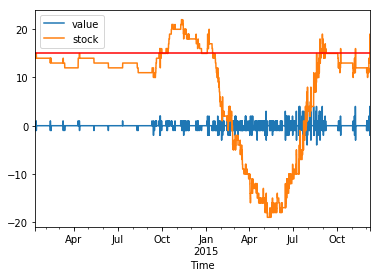

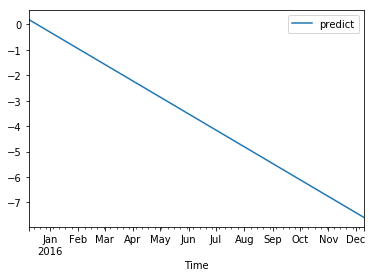

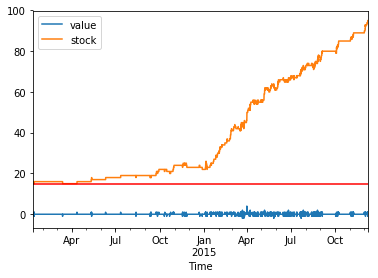

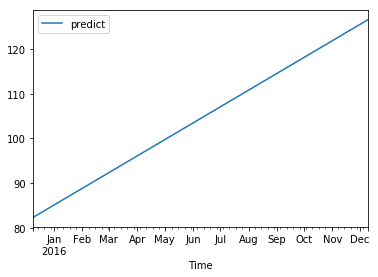

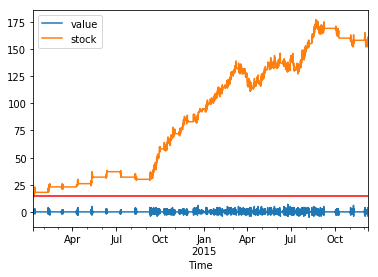

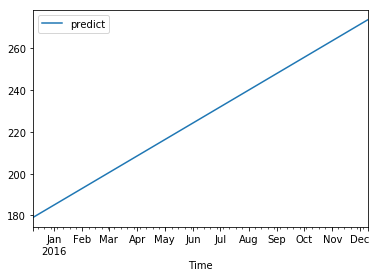

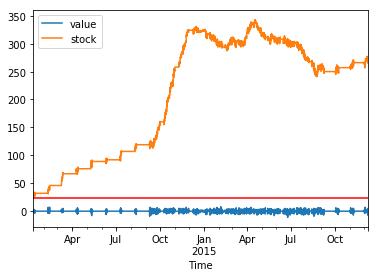

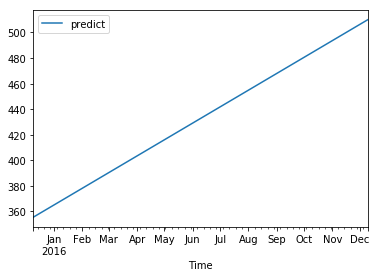

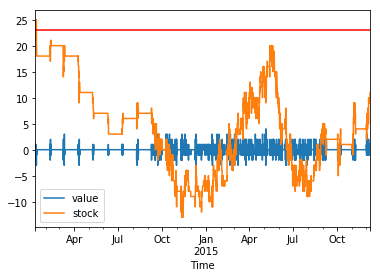

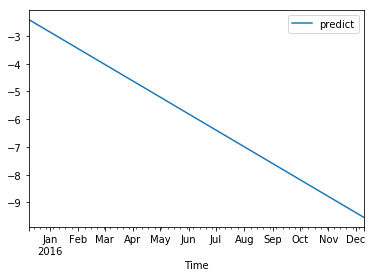

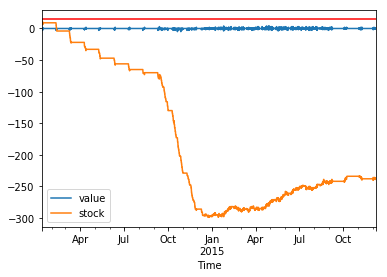

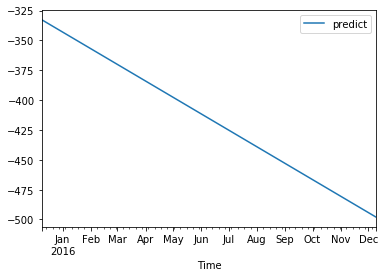

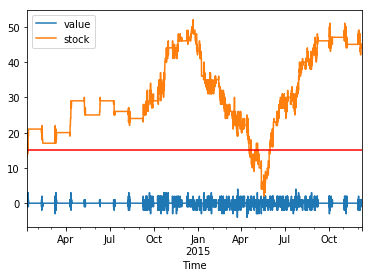

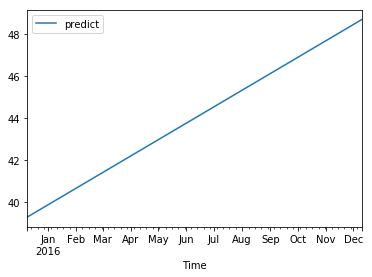

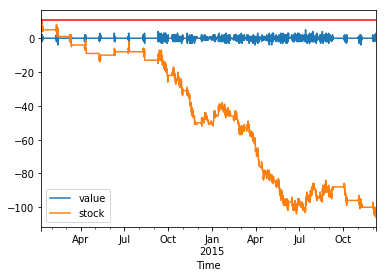

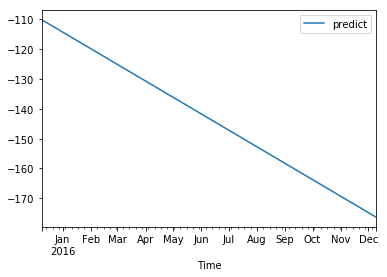

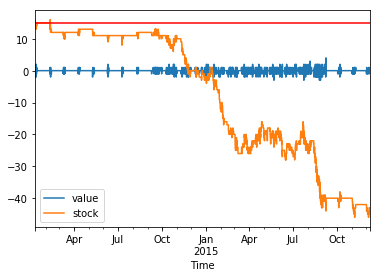

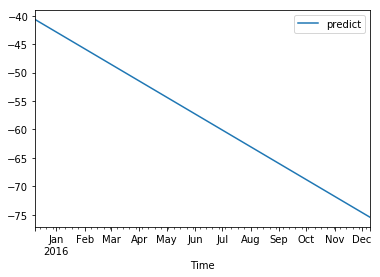

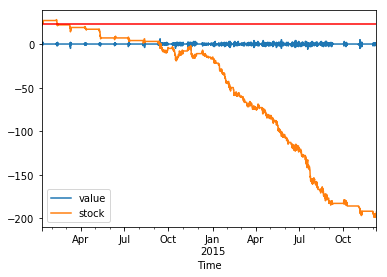

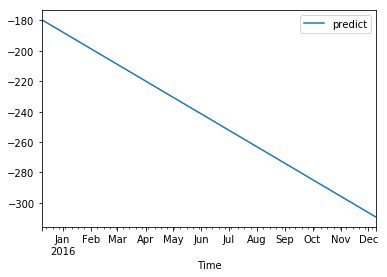

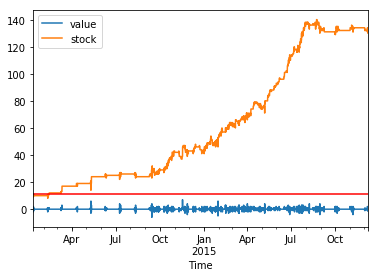

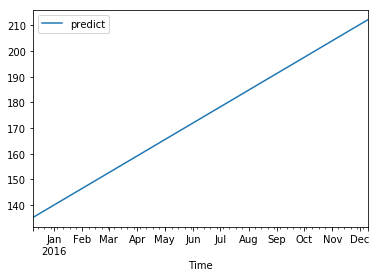

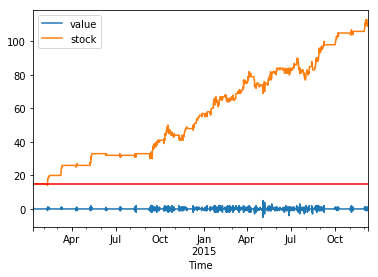

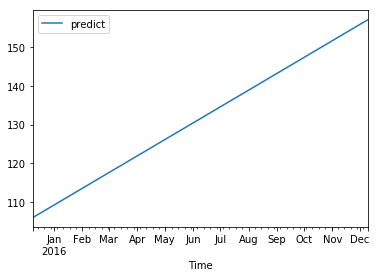

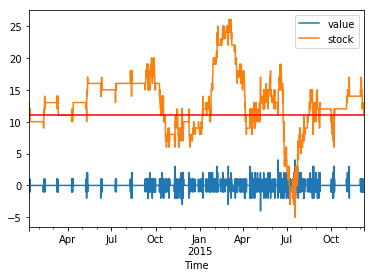

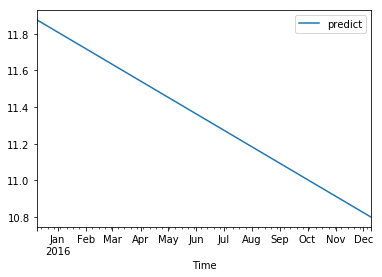

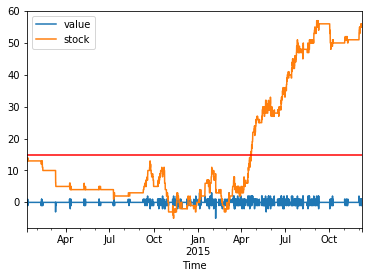

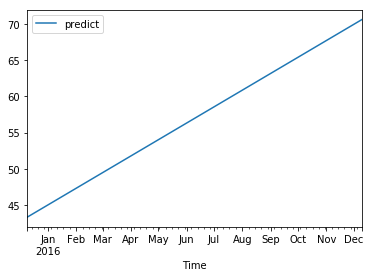

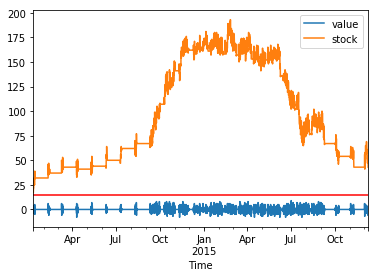

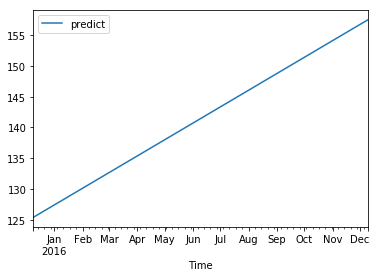

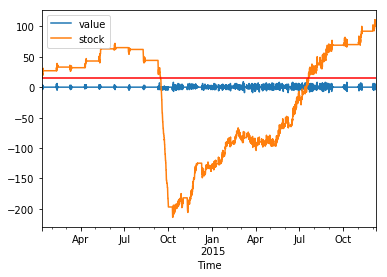

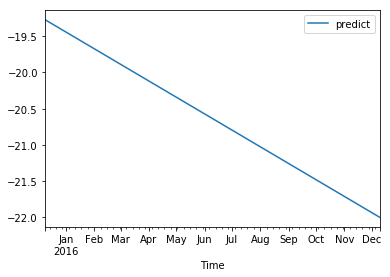

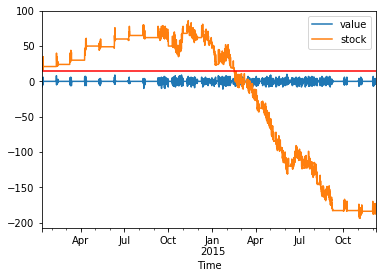

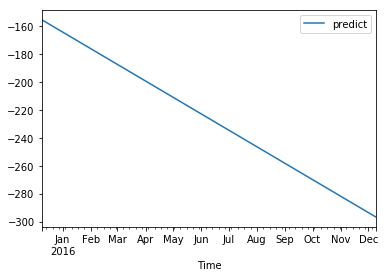

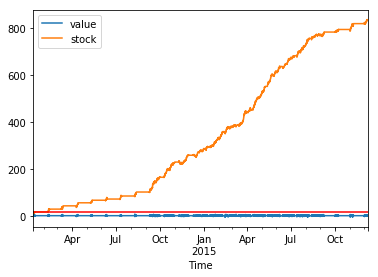

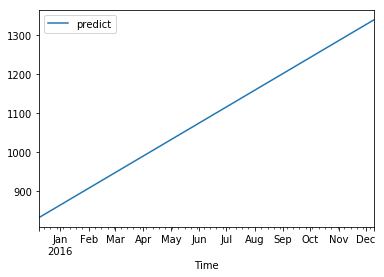

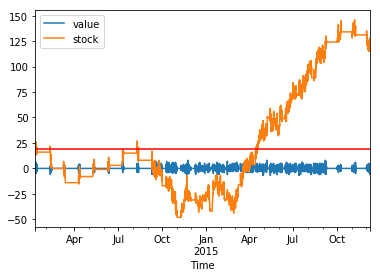

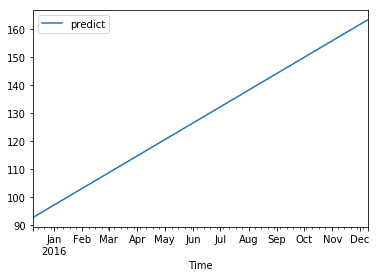

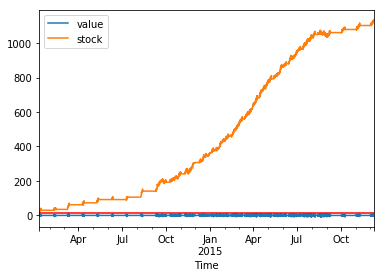

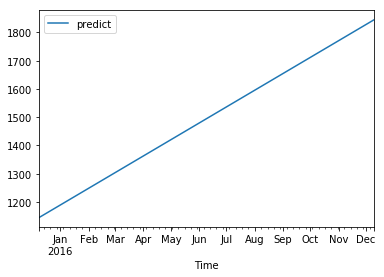

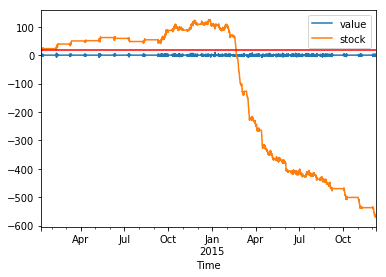

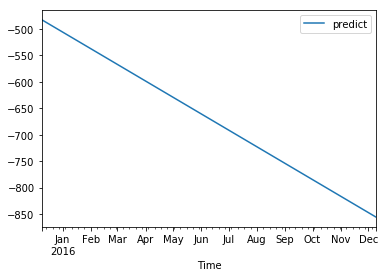

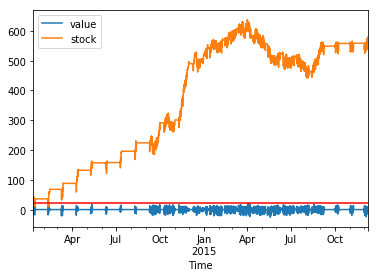

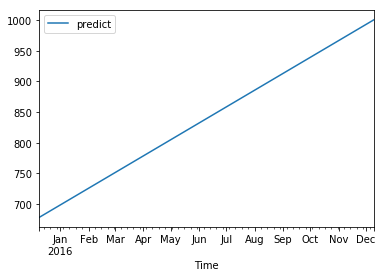

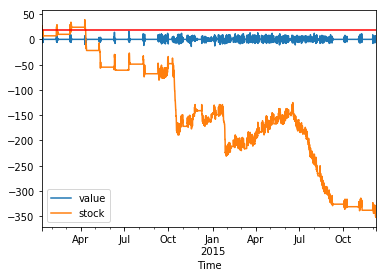

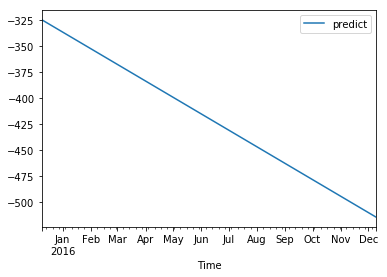

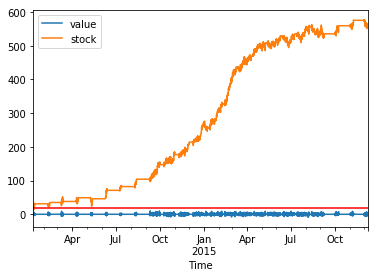

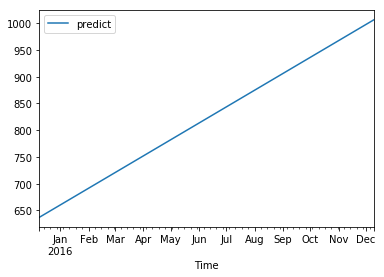

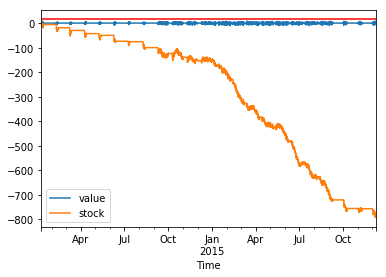

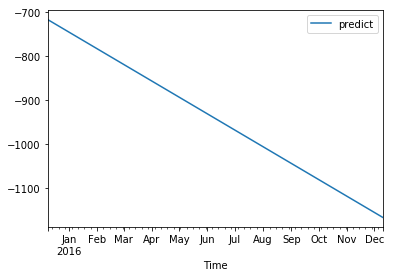

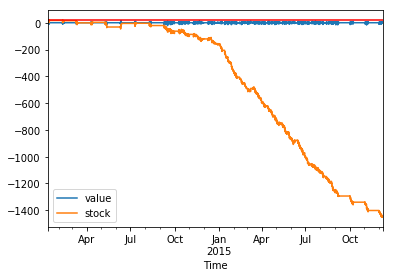

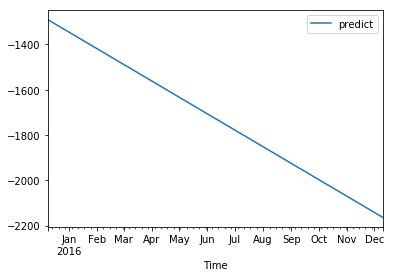

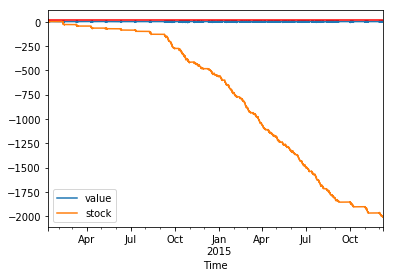

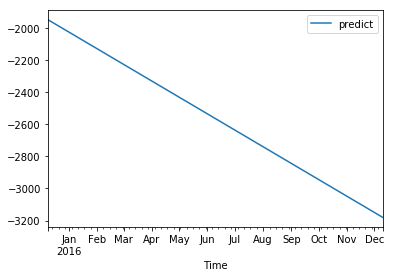

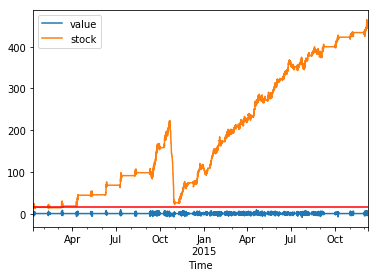

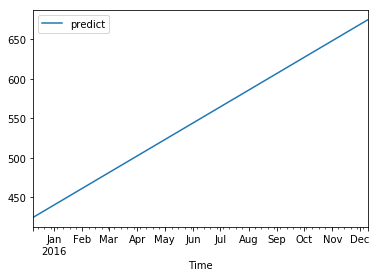

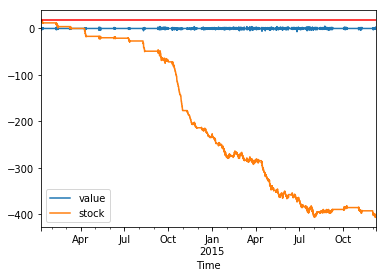

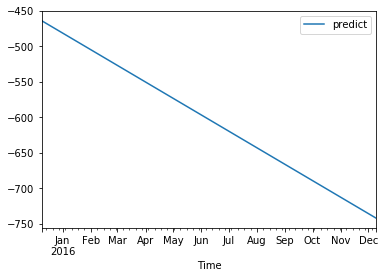

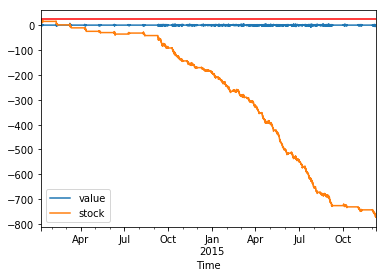

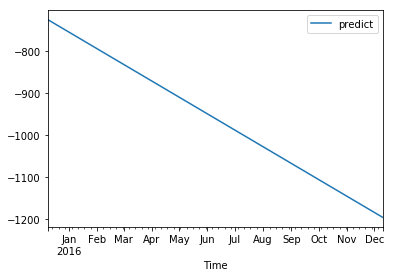

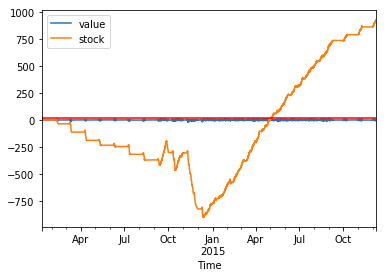

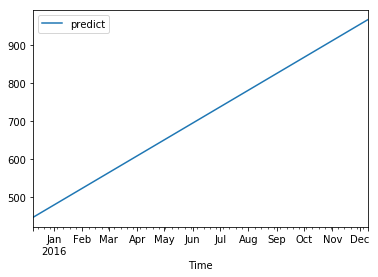

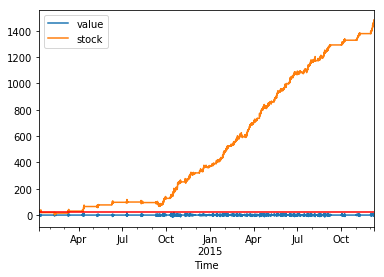

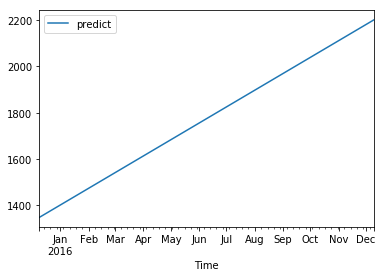

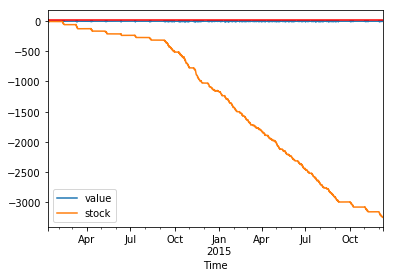

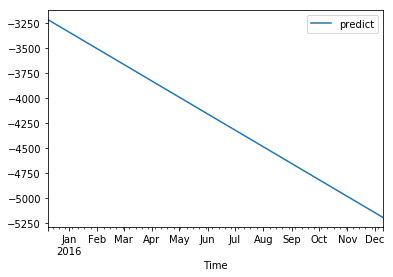

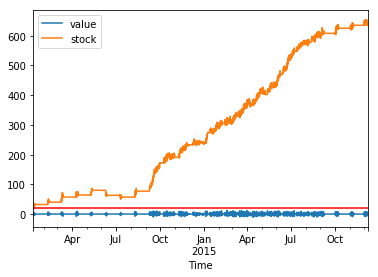

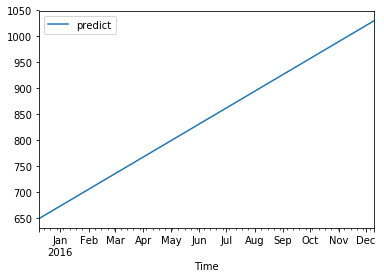

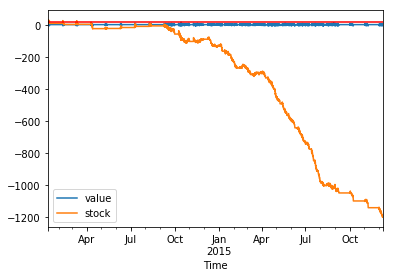

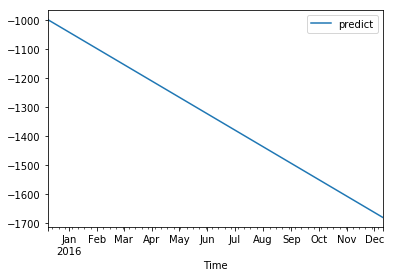

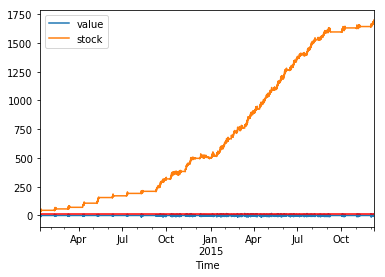

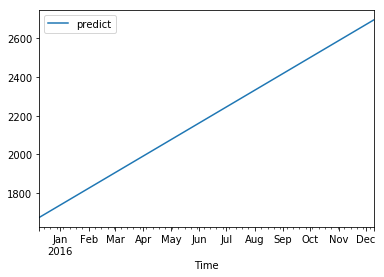

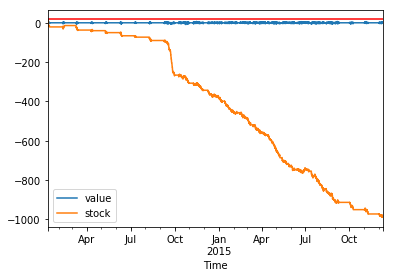

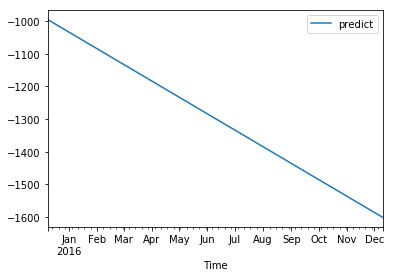

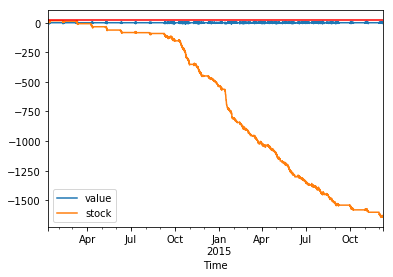

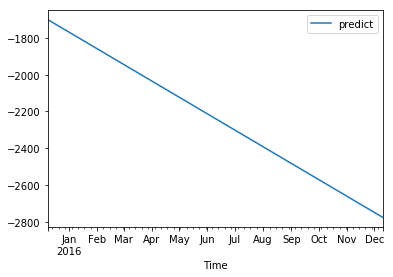

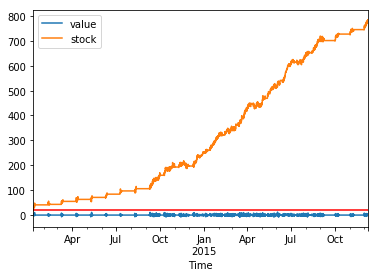

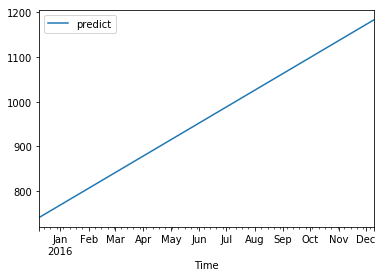

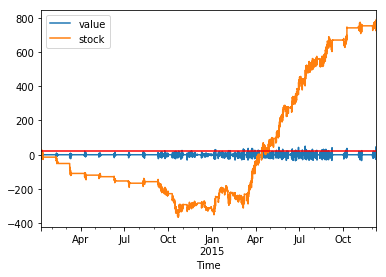

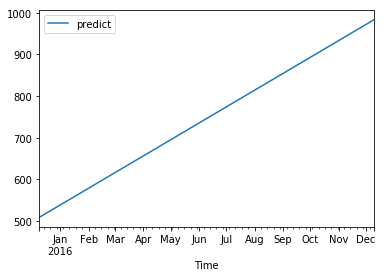

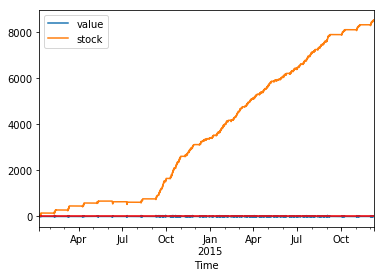

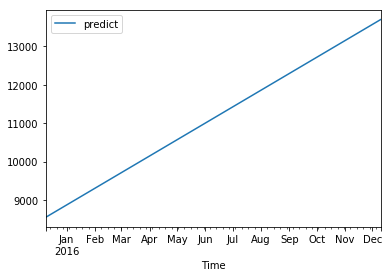

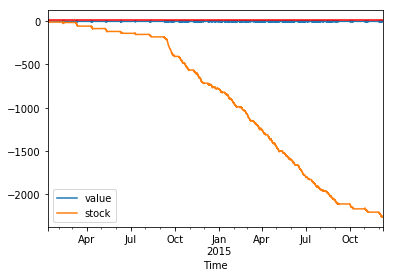

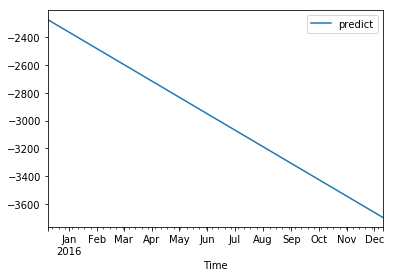

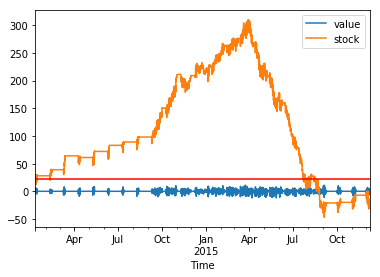

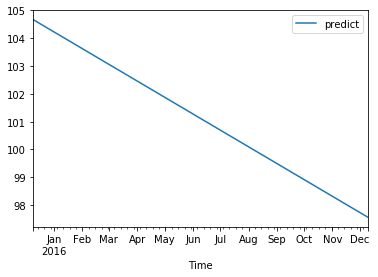

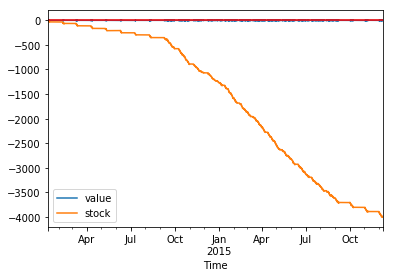

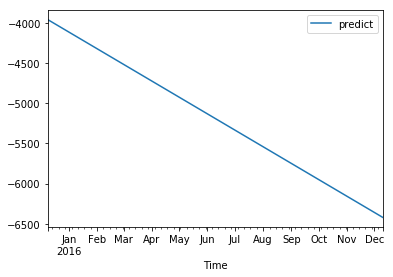

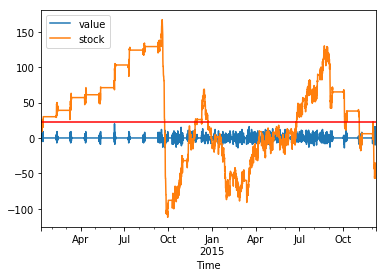

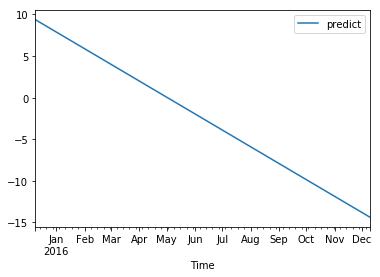

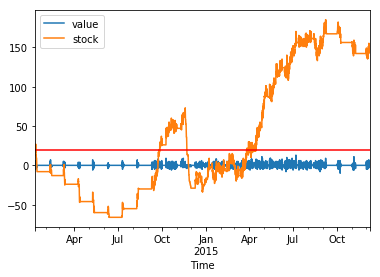

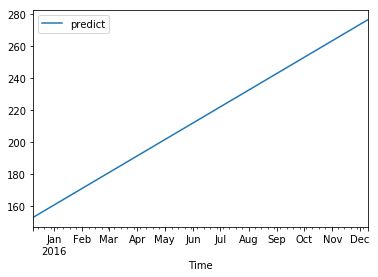

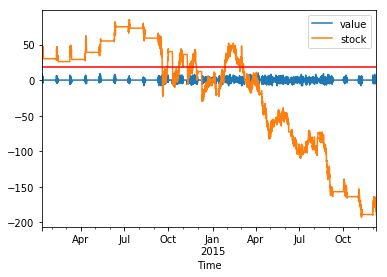

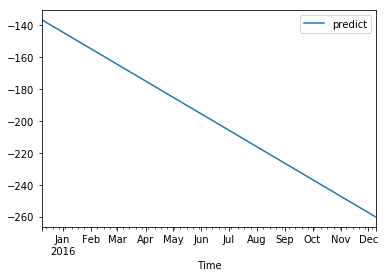

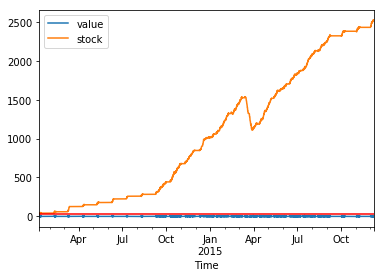

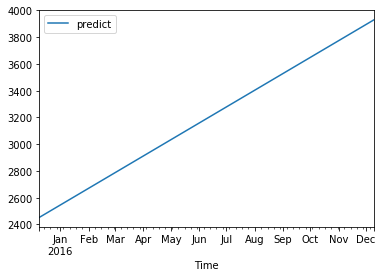

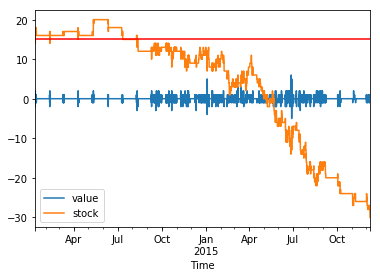

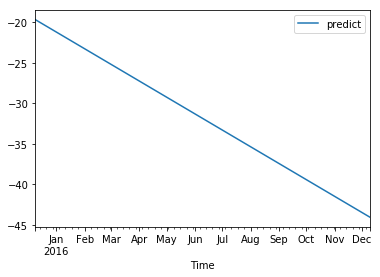

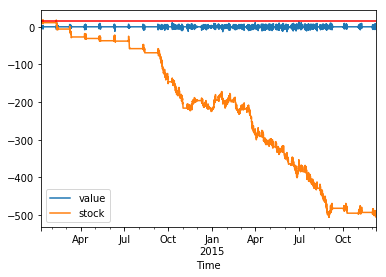

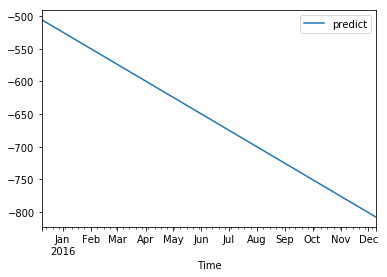

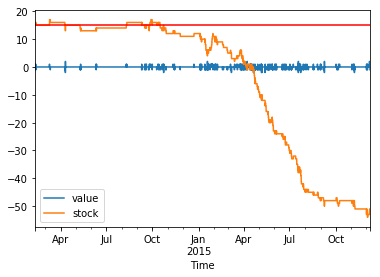

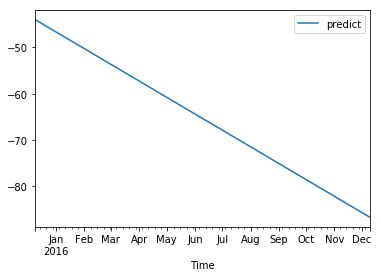

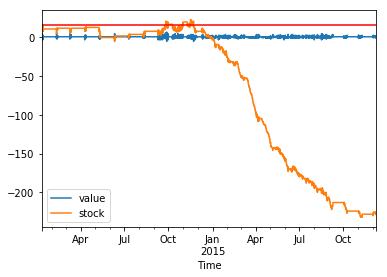

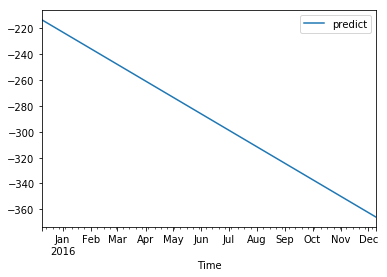

In [199]:
for id in Ids:
    df=df_dict[id]
    X=df.index
    X = X.values.reshape(-1,1)
    Y = df['stock'].values.reshape(-1,1)
    clf = LinearRegression()
    clf.fit(X,Y)
    new_X = pd.date_range("2015-12-09 00:00", "2016-12-09  23:00", freq="60min")
    df_predict = pd.DataFrame()
    df_predict['Time']=new_X
    df_predict = df_predict.set_index('Time')
    df_predict = df_predict.sort_index()
    df_predict = df_predict.groupby(pd.TimeGrouper(freq='H')).sum().fillna(0)
    new_X = (df_predict.index.values.reshape(-1,1))
    df_predict['predict'] = clf.predict(new_X.astype('float64', casting='unsafe'))
    df.plot()
    plt.axhline(y=station_dock[id], color='r', linestyle='-')
    df_predict.plot()